# Dopaminergic Connectivity

1. Import necessary packages
2. Wrangle the data
3. Plot the raw data
4. Generate a connectivity matrix

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
manifest = 'connectivity/mouse_connectivity_manifest.json'
mcc = MouseConnectivityCache(manifest_file=manifest)
structure_tree = mcc.get_structure_tree()

### Step 2. Wrangle the data

Below, we'll get the data for D1 and D2 with injections in the accumbens.

In [9]:
# retrieve structure information for the nucleus accumbens
accumbens_id = structure_tree.get_structures_by_acronym(['ACB'])[0]['id']

# get experiments by cre line and injection structure
drd1 = pd.DataFrame(mcc.get_experiments(cre=[ 'Drd1a-Cre_EY262' ], injection_structure_ids=[accumbens_id]))
drd1_unionizes = mcc.get_structure_unionizes(drd1['id'],is_injection=False,hemisphere_ids=[3])

drd2 = pd.DataFrame(mcc.get_experiments(cre=[ 'Drd2-Cre_ER44' ], injection_structure_ids=[accumbens_id]))
drd2_unionizes = mcc.get_structure_unionizes(drd2['id'],is_injection=False,hemisphere_ids=[3])

In [28]:
drd1_IDs = drd1_unionizes['experiment_id'].unique()
drd2_IDs = drd2_unionizes['experiment_id'].unique()
experiment_ids = list(np.concatenate((drd1_IDs,drd2_IDs)))
experiment_ids

[170785775, 168615344, 168614604, 167904966, 175732001]

### Step 3. Look at the projection maps

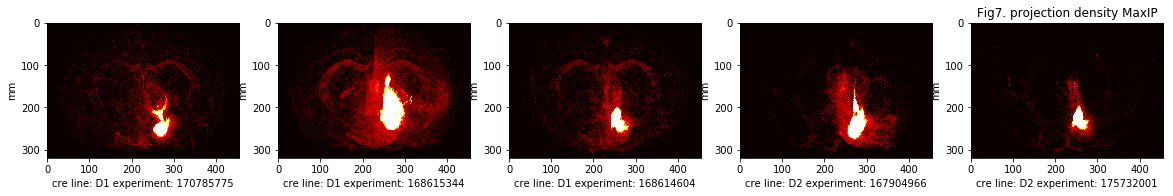

In [33]:
#experiment_ids = [all_IDs]
#experiment_ids = [170785775,168615344,168614604,167904966,175732001]
cre_lines = ['D1','D1','D1','D2','D2']

f, ax = plt.subplots(1,5, figsize=(20, 15))

count=0
for ID in experiment_ids:
    # projection density: number of projecting pixels / voxel volume
    proj_density, pd_info = mcc.get_projection_density(ID)
    pd_mip = proj_density.max(axis=0)

    ax[count].imshow(pd_mip, cmap='hot', aspect='equal')
    ax[count].set_xlabel("cre line: " + cre_lines[count] + " experiment: " +str(ID))
    ax[count].set_ylabel('mm')
    count+=1

plt.title("Fig7. projection density MaxIP")
plt.show()

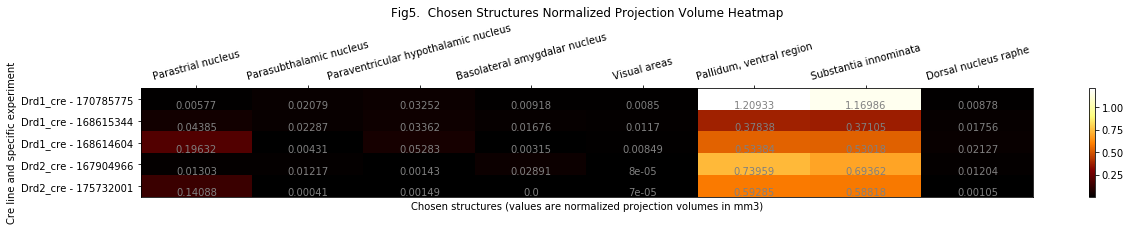

In [34]:
# ALL HEMISPHEREs (LEFT, RIGHT, BOTH)
# chosen experiments as explained above

searchfor = ['\\bPS\\b','\\bPSTN\\b','\\bPVH\\b',
             '\\bBLA\\b','\\bVIS\\b','\\bPALv\\b',
             '\\bSI\\b','\\bDR\\b']

to_plot = dataset[dataset.structure_acronym.str.contains('|'.join(searchfor))
       ].reset_index().drop('index',axis=1).set_index('structure_acronym').reindex (
        ['PS','PSTN','PVH','BLA','VIS','PALv','SI','DR'])

pm = mcc.get_projection_matrix(experiment_ids = [170785775,168615344,168614604,167904966,175732001],
                               projection_structure_ids=to_plot['structure_id'],
                               parameter = 'normalized_projection_volume',
                               hemisphere_ids = [3])

row_labels = ['Drd1_cre - 170785775','Drd1_cre - 168615344',
              'Drd1_cre - 168614604','Drd2_cre - 167904966','Drd2_cre - 175732001']
column_labels = pd.DataFrame(structure_tree.nodes(pd.DataFrame(pm['columns'])['structure_id']))['name']
matrix = pm['matrix']

fig, ax = plt.subplots(figsize=(20,2))
heatmap = ax.pcolor(matrix, cmap=plt.cm.afmhot)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(matrix.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(matrix.shape[0])+0.5, minor=False)

ax.set_xlim([0, matrix.shape[1]])
ax.set_ylim([0, matrix.shape[0]])          

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False)
ax.set_yticklabels(row_labels, minor=False)

for i in range(len(row_labels)):
    for j in range(len(column_labels)):
        text = ax.text(j+0.5, i+0.8, round(matrix[i, j],5),
                       ha="center", va="center", color="grey")

ax.set_ylabel('Cre line and specific experiment')
plt.title('Fig5.  Chosen Structures Normalized Projection Volume Heatmap')
ax.set_xlabel('Chosen structures (values are normalized projection volumes in mm3)')
plt.xticks(rotation=15)
plt.colorbar(heatmap)


plt.show()

In [49]:
# fetch the experiments that have injections in the primary visual cortex
VISp_IDs= structure_tree.get_structures_by_name(['Primary visual area'])[0]

ntsr_experiments = mcc.get_experiments(cre=['Ntsr1-Cre_GN220'], injection_structure_ids=[VISp_IDs['id']])
print("%d Ntsr1 cre cortical experiments" % len(ntsr_experiments))

rbp4_experiments = mcc.get_experiments(cre=['Rbp4-Cre_KL100'], injection_structure_ids=[VISp_IDs['id']])
print("%d Rbp4 cortical experiments" % len(rbp4_experiments))

16 Ntsr1 cre cortical experiments
20 Rbp4 cortical experiments


In [52]:
ctx_children

[593, 821, 721, 778, 33, 305]

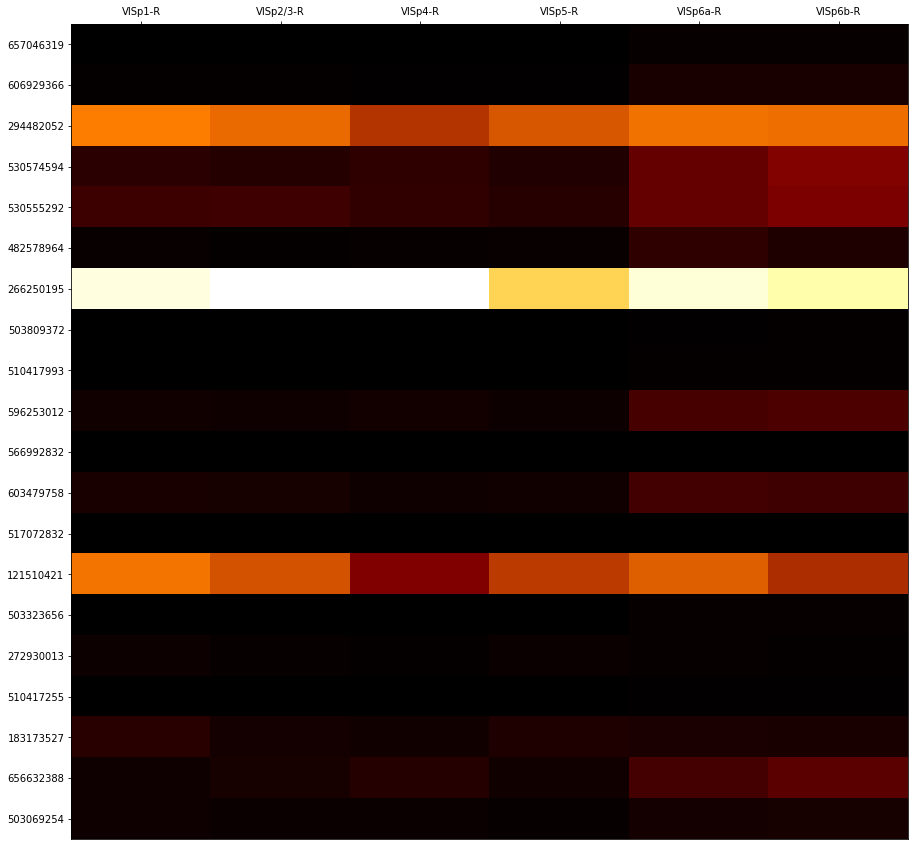

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

visp_experiment_ids = [ e['id'] for e in rbp4_experiments ]
ctx_children = structure_tree.child_ids( [VISp_IDs['id']] )[0]

pm = mcc.get_projection_matrix(experiment_ids = visp_experiment_ids, 
                               projection_structure_ids = ctx_children,
                               hemisphere_ids= [2], # right hemisphere, ipsilateral
                               parameter = 'projection_density')

row_labels = pm['rows'] # these are just experiment ids
column_labels = [ c['label'] for c in pm['columns'] ] 
matrix = pm['matrix']

fig, ax = plt.subplots(figsize=(15,15))
heatmap = ax.pcolor(matrix, cmap=plt.cm.afmhot)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(matrix.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(matrix.shape[0])+0.5, minor=False)

ax.set_xlim([0, matrix.shape[1]])
ax.set_ylim([0, matrix.shape[0]])          

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False)
ax.set_yticklabels(row_labels, minor=False)
plt.show()